# DACON 공모전 결과

준호랑 같이 객체 탐지 공모전에 참여했었고 faster rcnn, detr, yolo, retinanet 모델을 조금씩 튜닝하면서 학습했었는데 yolo 이외의 모델들이 bbox regression 에 비해 classification 을 잘 하지 못했습니다.

yolo 를 이용하여 결과물 제출했지만 private score 가 조금 떨어져서 아쉽게 본선을 가지 못했습니다.

# Focal Loss for Dense Object Detection
https://arxiv.org/pdf/1708.02002.pdf  
https://github.com/yhenon/pytorch-retinanet/blob/master/retinanet/losses.py  
https://github.com/pytorch/vision/blob/main/torchvision/models/detection/retinanet.py  





object detection 에서 높은 정확성을 가지는 방법들은 보통 R-CNN 계열의 two-stage 방식이다.
one-stage 방법은 보통 two-stage 보다 빠르고 간단하다는 장점이 있지만 정확성은 그에 미치지 못함.

저자들은 foreground-background class imblance 로 인해 dense detector 가 학습이 어려움을 발견하고 이를 해결하기 위한 방법으로 Focal Loss 를 제안함

## Focal Loss

class 가 너무 imblance 하여 학습이 제대로 되지 않고 쉽게 구분되는 negative sample 이 대부분으로 학습된다. 흔히 사용하는 weighted cross entropy 로는 positive/negative 를 구분하는데 유용하지만 easy/hard 를 구분 짓기는 어렵다.  

CE 에 modulating factor 를 붙인 Focal Loss 를 제안  
$$FL(p_t) = -(1-p_t)^γ \log (p_t)$$
- example 이 잘못 분류되고 $p_t$ 가 작을수록 modulating factor 는 1과 가깝게되고 loss 에는 영향을 주지 않음 반대로 $p_t$ 값이 크면 modulating factor 는 0에 가깝게 가고 loss 는 down-weight 된다. 즉 $\gamma$ 를 조정하여 easy example 에 대하여 loss 를 down-weight 할 수 있고 논문에서는 $\gamma=2$에서 가장 좋은 결과를 보임



## RetinaNet



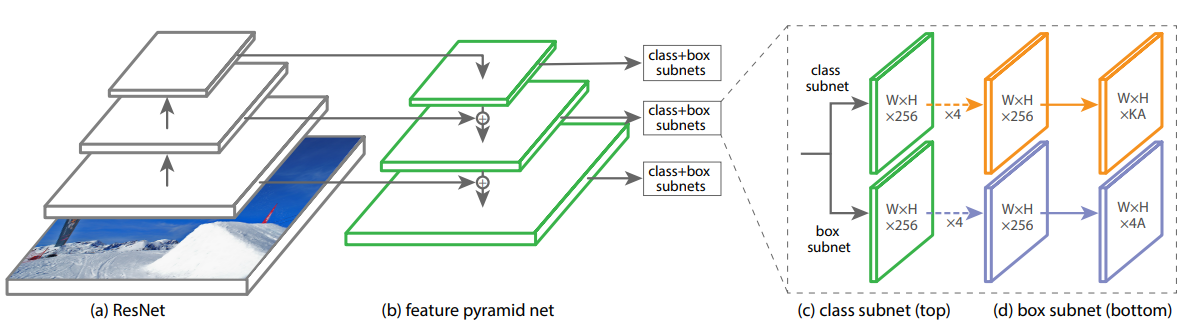

Focal loss 를 실험하기 위해 사용한 구조  

backbone 은 resnet 기반의 FPN 을 이용하여 multi-scale feature 를 추출하여 convolution layer 로 이루어진 subnetworks 에 입력하여 classification, box regression 을 수행




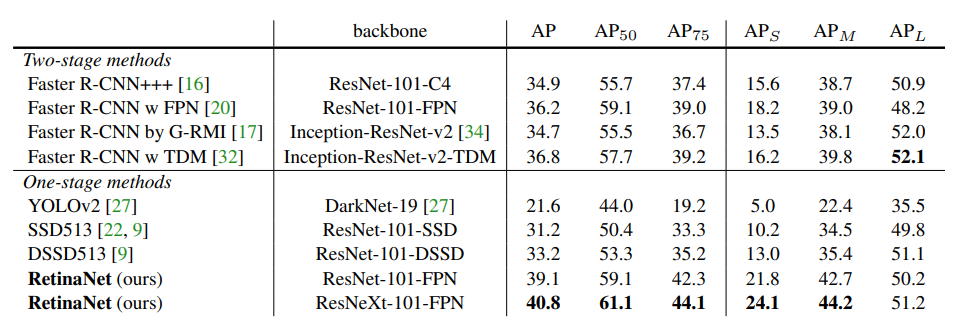

In [ ]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as rec

In [ ]:
# load model
w = torchvision.models.detection.RetinaNet_ResNet50_FPN_Weights.COCO_V1
model = torchvision.models.detection.retinanet_resnet50_fpn(weights=w)

# load dataset

dataset = torchvision.datasets.VOCDetection('./voc', '2007',
                                            'test', True, torchvision.transforms.ToTensor())

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 328MB/s]


Using downloaded and verified file: ./voc/VOCtest_06-Nov-2007.tar
Extracting ./voc/VOCtest_06-Nov-2007.tar to ./voc


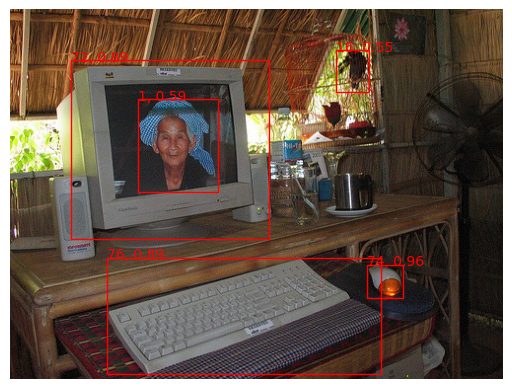

In [ ]:
idx = 210

model.eval()
x = [dataset[idx][0],]
pred = model(x)

boxes = pred[0]['boxes']
scores = pred[0]['scores']
labels = pred[0]['labels']

fig, axe = plt.subplots()
axe.imshow(np.transpose(dataset[idx][0],(1,2,0)))
for i in range(5):
    box = boxes[i]
    box = box.detach().cpu().numpy()
    r = rec((box[0],box[1]), box[2]-box[0], box[3]-box[1],
              facecolor='none', edgecolor='red')
    axe.add_patch(r)
    axe.text(box[0], box[1]+0.8, str(labels[i].item())+\
             f', {round(scores[i].item(),2)}', color='red')
axe.axis('off')
fig.show()